# 6.基因聚类与KEGG

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/huang/.conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 数据读入

In [2]:
subsample_adata = scv.read("./data/subsample_adata.h5ad") # 额外读取
adata = velovgi.tl.read_adata("./data/adata/")

batch_key = "stage"
cluster_key = "celltype"
pseudotime_key = "velocity_pseudotime"
subsample_adata, adata

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


(AnnData object with n_obs × n_vars = 4907 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
     uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovgi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 9815 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
     var: 'Acces

## 2. 基因聚类

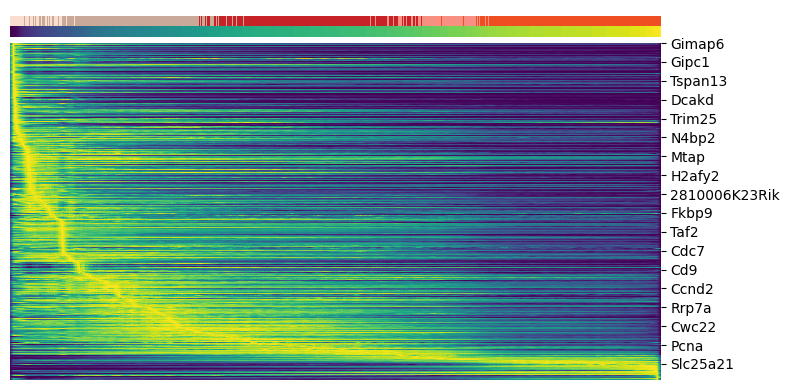

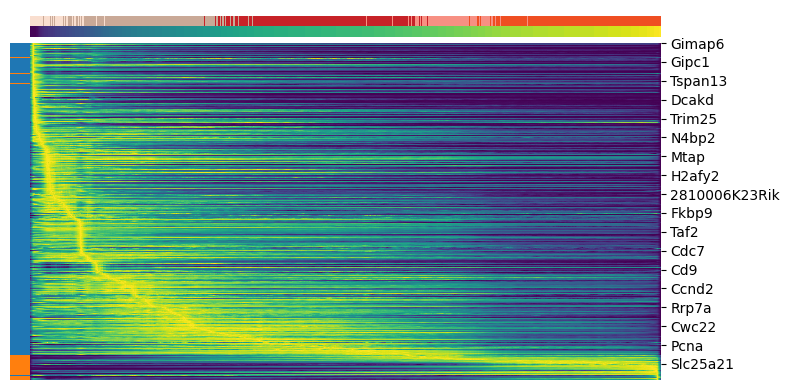

In [21]:
# 使用转换后的结果进行基因聚类
import seaborn as sns
from sklearn.cluster import KMeans

# 基因分类
k = 2 # 选择合适的聚类个数

top_genes = list(adata.var.index[:2000])
cm = scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", sort=True, col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, show=False) # 保存平滑之后的结果
df = cm.data2d # 这里提取出clustermap的结果
A = df.T.corr(method="spearman") # pearson相关性作为特征
classifier = KMeans(n_clusters=k, random_state=0).fit(A)
gene_cluster_list = classifier.labels_

# 颜色转换
color_dict = dict(enumerate(sns.palettes.color_palette()[:k]))
color_list = list(map(lambda x: color_dict[x], gene_cluster_list))

scv.pl.heatmap(adata, var_names=top_genes, sortby="velocity_pseudotime", col_color=[cluster_key, "velocity_pseudotime"], n_convolve=100, row_colors = color_list)

In [23]:
# sns.hetamap(A)

## 3. 基因聚类的平均值变化情况

([], [])

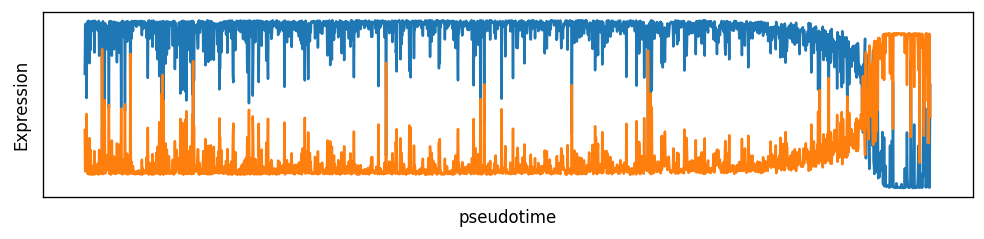

In [24]:
import matplotlib.pyplot as plt

A["gene_cluster"] = gene_cluster_list # 添加最后一列
mean_df = A.groupby("gene_cluster").mean().iloc[:, :-1].T # 去除最后一列

plt.figure(figsize=(10, 2), dpi=120)

for i in range(k):
    plt.plot(mean_df[i], color=color_dict[i])

plt.xlabel("pseudotime")
plt.xticks([])
plt.ylabel("Expression")
plt.yticks([])

## 4. KEGG富集成表格

In [25]:
import gseapy as gp


# 抽取各个聚类的基因名列表
gene_list_dict = {}
for i in range(k):
    gene_list = list(adata.var.index[gene_cluster_list==i])
    gene_list_dict[i] = gene_list

# 对各个聚类执行富集
kegg_df_dict = {}
for i in gene_list_dict.keys():
    print(i)
    kegg_df = gp.enrichr(gene_list_dict[i], gene_sets="KEGG_2019_Mouse").res2d
    kegg_df_dict[i] = kegg_df

kegg_df_dict[0]

0
1


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Cell cycle,46/123,1.628658e-17,4.657961e-15,0,0,6.021645,2.327739e+02,YWHAE;CDKN1C;GSK3B;CDKN1A;HDAC2;PCNA;CUL1;SMC3...
1,KEGG_2019_Mouse,Pathways in cancer,107/535,7.247631e-15,1.036411e-12,0,0,2.557992,8.328336e+01,SPI1;ITGA2B;ETS1;FGF3;IGF1R;CCND3;CCND2;PIM1;A...
2,KEGG_2019_Mouse,Focal adhesion,52/199,2.520786e-12,2.403149e-10,0,0,3.563728,9.517452e+01,ITGB1;GSK3B;FLT1;ITGB3;ITGA2B;ACTB;ARHGAP35;IG...
3,KEGG_2019_Mouse,Regulation of actin cytoskeleton,53/217,2.582293e-11,1.846339e-09,0,0,3.254494,7.934377e+01,ITGB1;CYFIP1;ARPC1B;ITGB3;ITGA2B;WASL;ACTB;ARH...
4,KEGG_2019_Mouse,Protein processing in endoplasmic reticulum,43/163,1.399399e-10,8.004560e-09,0,0,3.597292,8.162186e+01,PPP1R15A;TRAM1;HSP90AB1;TUSC3;UBE2D3;RPN1;CUL1...
...,...,...,...,...,...,...,...,...,...,...
281,KEGG_2019_Mouse,Oxidative phosphorylation,4/134,9.987864e-01,9.999952e-01,0,0,0.302162,3.669308e-04,UQCRB;COX17;COX6B2;ATP5G1
282,KEGG_2019_Mouse,Chemical carcinogenesis,2/94,9.988095e-01,9.999952e-01,0,0,0.213701,2.545693e-04,MGST3;GSTM5
283,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,12/292,9.997308e-01,9.999952e-01,0,0,0.419193,1.128603e-04,BMP4;BMP2;TGFB1;IFNGR2;TNFRSF9;MPL;LIFR;IL11RA...
284,KEGG_2019_Mouse,Olfactory transduction,5/1133,9.999934e-01,9.999952e-01,0,0,0.041142,2.732215e-07,GNB1;CALM3;CALM1;CALM2;ANO2


In [26]:
kegg_df_dict[1]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Purine metabolism,5/136,0.004781,0.343496,0,0,4.853238,25.931541,PRPS2;PRPS1;PKM;HPRT;PFAS
1,KEGG_2019_Mouse,Ubiquitin mediated proteolysis,5/138,0.005084,0.343496,0,0,4.779772,25.245525,FBXW7;NEDD4;XIAP;SIAH1B;CUL4B
2,KEGG_2019_Mouse,Other glycan degradation,2/18,0.008946,0.343496,0,0,15.683544,73.971742,GLB1;HEXA
3,KEGG_2019_Mouse,Protein processing in endoplasmic reticulum,5/163,0.010091,0.343496,0,0,4.018375,18.468704,BCAP31;HSPA8;SSR4;PRKCSH;STT3B
4,KEGG_2019_Mouse,Glycosaminoglycan degradation,2/21,0.012088,0.343496,0,0,13.205197,58.307830,GLB1;HEXA
...,...,...,...,...,...,...,...,...,...,...
159,KEGG_2019_Mouse,Ras signaling pathway,1/233,0.847787,0.868981,0,0,0.531555,0.087774,RASSF1
160,KEGG_2019_Mouse,Human T-cell leukemia virus 1 infection,1/245,0.861934,0.877995,0,0,0.505104,0.075046,XIAP
161,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,1/292,0.905832,0.917016,0,0,0.422508,0.041786,ACVR2B
162,KEGG_2019_Mouse,PI3K-Akt signaling pathway,1/357,0.944612,0.950407,0,0,0.344216,0.019614,COL4A2


In [27]:
# 看看此处富集的通路与CellDancer中哪些出现了
pathway_list = [
    "Angiogenesis",
    "Vasculogenesis",
    "Wound healing",
    "Actin cytoskeleton organization",
    "Cell division",
    "Cell cycle",
    "Chromatin organization",
    "RNA splicing",
    "Translation",
    "Carboxylic acid metabolic process",
    "Erythrocyte development",
    "Heme biosynthetic process",
    "Oxygen transport",
    "Cellular oxidant detoxification"
]
for i in kegg_df_dict.keys():
    print(i)
    kegg_df = kegg_df_dict[i]
    for term in kegg_df["Term"]:
        if term in pathway_list:
            print(term)
# 出现的并不多，那暂时自己找几个吧

0
Cell cycle
1
Cell cycle


In [28]:
for i in kegg_df_dict.keys():
    print(kegg_df_dict[i].head()["Term"])

0                                     Cell cycle
1                             Pathways in cancer
2                                 Focal adhesion
3               Regulation of actin cytoskeleton
4    Protein processing in endoplasmic reticulum
Name: Term, dtype: object
0                              Purine metabolism
1                 Ubiquitin mediated proteolysis
2                       Other glycan degradation
3    Protein processing in endoplasmic reticulum
4                  Glycosaminoglycan degradation
Name: Term, dtype: object


,Cell cycle,Pathways in cancer,Focal adhesion,Regulation of actin cytoskeleton,Protein processing in endoplasmic reticulum,Progesterone-mediated oocyte maturation,Long-term depression,Protein processing in endoplasmic reticulum,Leukocyte transendothelial migration,Ubiquitin mediated proteolysis
0,4.657961e-15,1.036411e-12,2.403149e-10,1.846339e-09,8.004560e-09,0.006402,0.133916,8.004560e-09,1.828587e-08,0.004106
1,7.418268e-01,7.418268e-01,7.418268e-01,7.700955e-01,3.434961e-01,0.607610,0.702972,3.434961e-01,3.434961e-01,0.343496


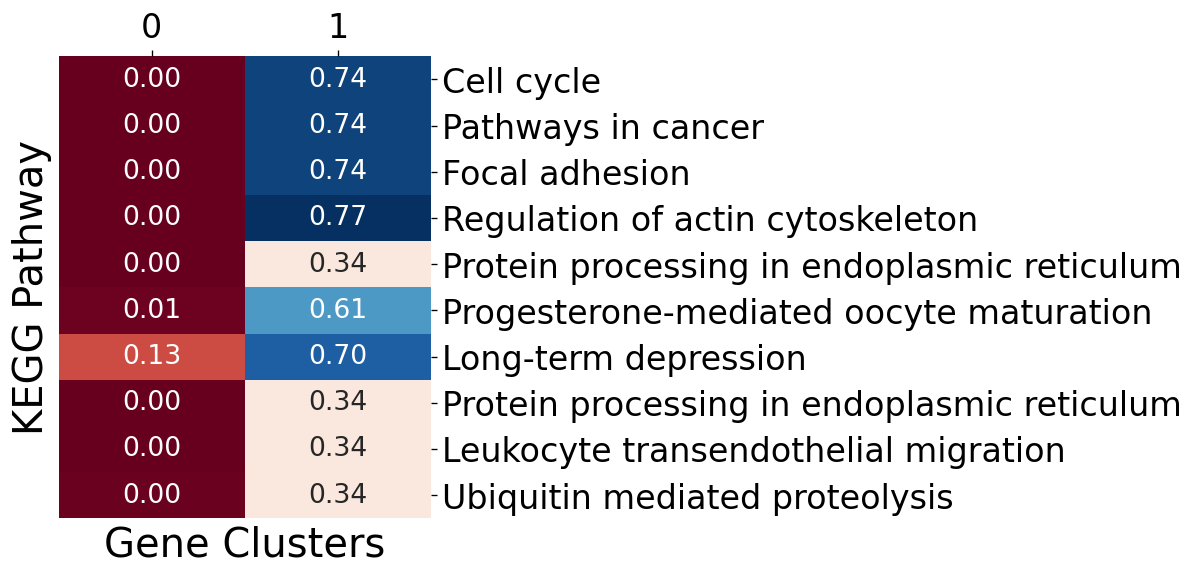

In [31]:
import numpy as np
import pandas as pd

plt.figure(figsize=(4,5), dpi=120)
pathway_list = [
    "Cell cycle",
    "Pathways in cancer",
    "Focal adhesion",
    "Regulation of actin cytoskeleton",
    "Protein processing in endoplasmic reticulum",
    "Progesterone-mediated oocyte maturation",
    "Long-term depression",
    "Protein processing in endoplasmic reticulum",
    "Leukocyte transendothelial migration",
    "Ubiquitin mediated proteolysis"
]

df = pd.DataFrame(np.ones((k, len(pathway_list))), columns=pathway_list)

for i in kegg_df_dict.keys():
    kegg_df = kegg_df_dict[i]
    for pathway in pathway_list:
        if pathway in list(kegg_df["Term"]):
            pvalue = float(kegg_df[kegg_df["Term"] == pathway]["Adjusted P-value"])
            df.loc[i,pathway] = pvalue # 有该通路则更新值

# 表格还需要美化
ax = sns.heatmap(df.T, annot=True, fmt=".2f", cbar=False, cmap="RdBu", annot_kws={"fontsize":16}, )

ax.xaxis.set_ticks_position("top") 
ax.yaxis.set_ticks_position("right") 
plt.xticks(fontsize=20, rotation=0)
plt.yticks(fontsize=20, rotation=0)

plt.xlabel("Gene Clusters", fontsize=24)
plt.ylabel("KEGG Pathway", fontsize=24)

## 5. 色带绘制

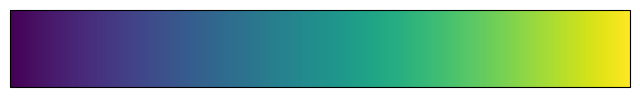

In [30]:
import matplotlib as mpl

# 基因表达随时间变化色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

# 干脆文字部分都不要了
cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)

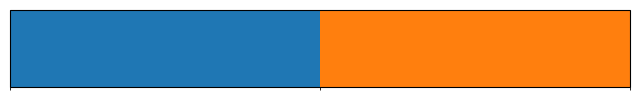

In [32]:
# 基因聚类色带
colors = color_dict.values()
fig, ax = plt.subplots(figsize=(8, 1))
cmap = mpl.colors.ListedColormap(colors) # 指定离散颜色
bounds = range(len(colors)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[]
)

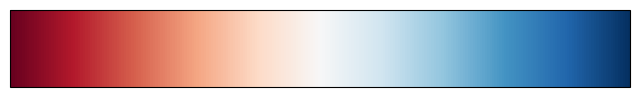

In [33]:
# 显著性色带
fig, ax = plt.subplots(1, 1, figsize=(8, 1))
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)
im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

cbar = fig.colorbar(
    im, cax=ax, orientation="horizontal",
    ticks=[],
)